In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os

In [4]:
from kaggle_submit import submit_to_kaggle
from helpers import *
from utils.globals import *
from utils.distribution_statistics import *

train_file = "kaggle_data/X_train.h5/X_train.h5"
test_file = "kaggle_data/X_test.h5/X_test.h5"

h5_train = h5py.File(train_file, mode='a')
h5_test = h5py.File(test_file, mode='a')

y_train = pd.read_csv("kaggle_data/y_train.csv", index_col=0, squeeze=True)
y_train_arr = y_train.to_numpy()

# MAKE CUSTOM FEATURES
from additional_features.make_features import make_all_features
make_all_features(h5_train, h5_test, n_chunks=10, verbose=True, overwrite=False)


from objects import *

In [5]:
def ensure_integrity(h5_file):
    keys = list(h5_file.keys())
    for i, key in enumerate(keys):
        print_bis(f'{i+1}/{len(keys)}')
        x = h5_file[key][:]
        assert np.sum(np.isnan(x)) == 0
        assert np.sum(np.isinf(x)) == 0
        
# ensure_integrity(h5_train)
# ensure_integrity(h5_test)

In [6]:
"""
# SAVE MODEL

from joblib import dump, load
ARCHIVES_FOLDER = "models_archives"
if not os.path.exists(ARCHIVES_FOLDER):
    os.makedirs(ARCHIVES_FOLDER)

def save_model(model, name):
    fpath = os.path.join(ARCHIVES_FOLDER, f"{name}.joblib")
    dump(model, fpath)
    print(f"New model saved at {fpath}")
    return fpath
    
    
def load_model(name):
    if not name.startswith(ARCHIVES_FOLDER):
        name = os.path.join(ARCHIVES_FOLDER, name)
    if not name.endswith(".joblib"):
        name = f"{name}.joblib"
    model = load(name)
    return model

LEADERBOARD_FILE = "leaderboard.txt"
if not os.path.exists(LEADERBOARD_FILE):
    with open(LEADERBOARD_FILE, 'a') as leaderboard:
        leaderboard.write(";;;".join(['path', 'training_score', 'validation_score', 'comments']))
    
def write_model_to_leaderboard(model, model_name, train_score, val_score, comments=""):
    fpath = save_model(model, model_name)
    with open(LEADERBOARD_FILE, "a") as leaderboard:
        leaderboard.write("\n" + ';;;'.join([fpath, str(train_score), str(val_score), comments]))
    
"""
_ = ""

In [7]:
## Input maker

def make_input_for_svm_extreme(h5_file):
    return make_input(h5_file, features=FEATURES, quantiles=TAIL_QUANTILES, dist_char=False, truncate_dist=False)

svm_extreme_input_maker = InputMaker(make_input_for_svm_extreme)

## input shaper
import re
from sklearn.preprocessing import StandardScaler

pca_cols_filters = [
    lambda x: 'eeg' in x[0] and 'logmod' in x[0], 
    lambda x: bool(re.search('eeg_\d', x[0])),
]

pca_list = [CustomPCA(columns_filter=filt, name=f"PCA_{i}", var_capture=0.95) for i, filt in enumerate(pca_cols_filters)]

svm_extreme_input_shaper = InputShaper(*pca_list, StandardScaler())

## parameters grid
from sklearn.model_selection import ParameterGrid

svm_grid_1 = ParameterGrid({"kernel": ["rbf", "sigmoid"],
                            "C": [0.01, 0.1, 1, 10, 100],
                            "gamma": ["auto", "scale"]}
                          )
svm_grid_2 = ParameterGrid({"kernel": ["poly"],
                            "C": [0.01, 0.1, 1, 10, 100],
                            "degree": [1, 2, 3, 4]}
                          )
svm_hyperparameters = list(svm_grid_1) + list(svm_grid_2)


# generic object
from sklearn.svm import SVC

svm_extreme = PoolModels(
    input_maker=svm_extreme_input_maker,
    n_splits=5,
    train_size=27,
    input_shaper=svm_extreme_input_shaper,
    blueprint=SVC,
    parameters_list=svm_hyperparameters,
    warming_params={"max_iter":10},
    convergence_params={"max_iter": -1},
    seed=3,
    h5_train=h5_train,
    h5_test=h5_test,
    y_train_arr=y_train_arr
)

# train
import matplotlib.pyplot as plt
#svm_extreme.warm_up()
#svm_extreme.plot_validation()
#plt.show()
#best_svm_extremes = svm_extreme.train_n_best_models_until_convergence(3)

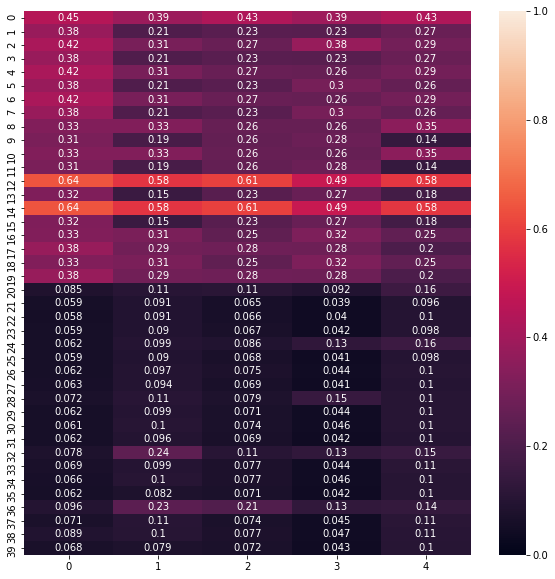

In [7]:
for split_num in [1, 2, 3, 4]:
    svm_extreme.train_n_best_models_until_convergence(n=3, split_num=split_num)
svm_extreme.plot_validation()

In [ ]:
# SVM glouton

# input_maker

def make_input_glouton(h5_file):
    return make_input(h5_file, features=FEATURES, quantiles=QUANTILES, dist_char=True, truncate_dist=True)

glouton_im = InputMaker(make_input_glouton)

# input_shaper 
def make_filter(pat):
    def f(col_tup):
        return bool(re.search(pat, col_tup[0]))
    return f

groups_pats = ["alpha", "beta", "delta", "theta", "eeg_\d.*logmod"]
custom_pcas = [CustomPCA(make_filter(gp), name=gp, var_capture=0.95) for gp in groups_pats]
glouton_is = InputShaper(*custom_pcas, StandardScaler())

glouton_pool = PoolModels(
    input_maker=glouton_im,
    n_splits=5,
    train_size=27,
    input_shaper=glouton_is,
    blueprint=SVC,
    parameters_list=svm_hyperparameters,
    iterations_to_warm=100,
    seed=3,
    h5_train=h5_train,
    h5_test=h5_test,
    y_train_arr=y_train_arr
)

glouton_pool.warm_up()
glouton_pool.plot_validation()
plt.show()
best_gloutons = glouton_pool.train_n_best_models_until_convergence(5)

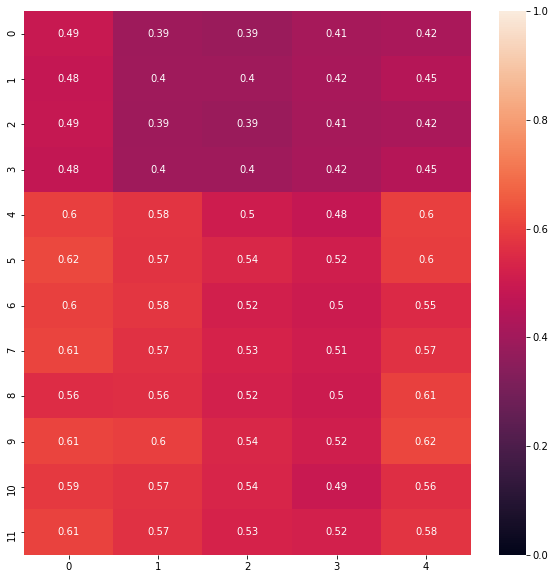

In [6]:
# RandomForest glouton

# input_maker

def make_input_glouton(h5_file):
    return make_input(h5_file, features=FEATURES, quantiles=QUANTILES, dist_char=True, truncate_dist=True)

glouton_im = InputMaker(make_input_glouton)

# input_shaper 
def make_filter(pat):
    def f(col_tup):
        return bool(re.search(pat, col_tup[0]))
    return f

groups_pats = ["alpha", "beta", "delta", "theta", "eeg_\d.*logmod"]
custom_pcas = [CustomPCA(make_filter(gp), name=gp, var_capture=0.95) for gp in groups_pats]
glouton_is = InputShaper(*custom_pcas, StandardScaler())

# Hyperparameters griabsd
random_forest_params = {
    "n_estimators": [10, 100],
    "max_depth": [3, 10, 30],
    "min_samples_leaf": [10, 100]
}

rf_hyperparameters = list(ParameterGrid(random_forest_params))

from sklearn.ensemble import RandomForestClassifier

rf_glouton_pool = PoolModels(
    input_maker=glouton_im,
    n_splits=5,
    train_size=27,
    input_shaper=glouton_is,
    blueprint=RandomForestClassifier,
    parameters_list=rf_hyperparameters,
    warming_params={},
    convergence_params={},
    seed=3,
    h5_train=h5_train,
    h5_test=h5_test,
    y_train_arr=y_train_arr
)

rf_glouton_pool.warm_up()
rf_glouton_pool.plot_validation()
plt.show()
# rf_best_gloutons = rf_glouton_pool.train_n_best_models_until_convergence(5)

<AxesSubplot:>

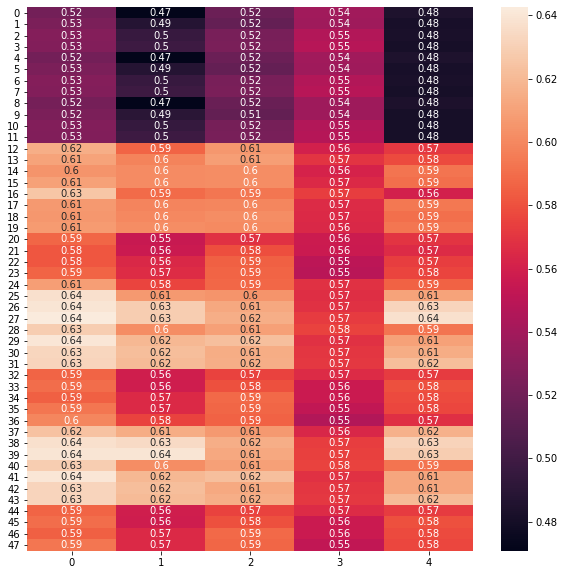

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(rf_glouton_pool.validation_scores, ax=ax, annot=True)

In [8]:
eeg_1_mean = np.mean(h5_train["eeg_1"][:], axis=1)


In [9]:
sleep_stages = y_train_arr

def mean_stat(feat):
    mean_samples = np.mean(h5_train[feat][:], axis=1)
    df = pd.DataFrame(mean_samples, columns=[feat], index=y_train_arr)
    return df.groupby(df.index).agg([np.mean, np.std])

def quantile_stat(feat, func_arr=lambda x: np.mean(x, axis=1), quantiles=np.linspace(0.1, 0.9, 9).round(2)):
    samples_stat = func_arr(h5_train[feat][:])
    df = pd.DataFrame(samples_stat, columns=[feat], index=y_train_arr)
    quantiles_df = df.groupby(df.index).apply(lambda x: np.quantile(x, q=quantiles))
    quantiles_df = np.array(quantiles_df.tolist())
    quantiles_df = pd.DataFrame(quantiles_df, columns=[str(q) for q in quantiles])
    return quantiles_df

def plot_quantile_stat(features, func_arr, func_name, quantiles, logscale=False):
    for feat in features:
        qstat = quantile_stat(feat, func_arr, quantiles=quantiles)
        # print(qstat)
        for i in range(len(qstat.columns)):
            plt.scatter(qstat.index, qstat.values[:, i])
        plt.title(feat + f" quantiles of {func_name}")
        if logscale:
            plt.yscale("log")
        plt.show()

def create_quantile_plot():
    pass
        


# z = quantile_stat("eeg_1")

In [16]:
def moment(arr, order, diff_order):
    return np.mean(differentiate(arr, diff_order) ** order, axis=1)

f = lambda x: moment(np.exp(x), order=2, diff_order=2)
# f = lambda x: np.quantile(x, q=0.9, axis=1) - np.quantile(x, q=0.1, axis=1)
plot_quantile_stat(SPECTRAL_FEATURES, f, "", quantiles=[0.05,0.3, 0.5, 0.7,0.95], logscale=True)

ValueError: Not a location (invalid object ID)

In [30]:
np.quantile(np.arange(100), q=0.9) - np.quantile(np.arange(100), q=0.1)

79.2

In [48]:
SPECTRAL_FEATURES

['accel_norm_ft_logmod',
 'eeg_1_ft_logmod',
 'eeg_2_ft_logmod',
 'eeg_3_ft_logmod',
 'eeg_4_ft_logmod',
 'eeg_5_ft_logmod',
 'eeg_6_ft_logmod',
 'eeg_7_ft_logmod',
 'pulse_ft_logmod',
 'speed_norm_ft_logmod']

In [15]:
h5_train.close()
h5_test.close()